In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sys.path.insert(0, '/Users/Kwat/binf/cca')
import ccal

%matplotlib inline

==================== Computational Cancer Analysis Library ====================

<10:20:35.223008> Checking dependencies ...
<10:20:35.225301> Using the following packages:
<10:20:35.226978> 	matplotlib (v1.5.1)
<10:20:35.226996> 	numpy (v1.10.4)
<10:20:35.227004> 	pandas (v0.18.0)
<10:20:35.227025> 	rpy2 (v2.7.9)
<10:20:35.227033> 	scikit-learn (v0.17.1)
<10:20:35.227040> 	scipy (v0.17.0)
<10:20:35.227048> 	seaborn (v0.7.0)


# Make test data

In [40]:
nrow = 50
nrow_2 = nrow + 30
ncol = 200
ncol_2 = ncol + 30

row_names = ['feature {}'.format(i) for i in range(nrow)]
row_names_2 = ['feature {}'.format(i) for i in range(nrow_2)]
col_names = ['elemenet {}'.format(i) for i in range(ncol)]
col_names_2 = ['elemenet {}'.format(i) for i in range(ncol_2)]

features = pd.DataFrame(np.random.random((nrow_2, ncol_2)),
                        index=row_names_2,
                        columns=col_names_2)
scores = pd.DataFrame(np.random.rand(nrow), index=row_names, columns=['p-value'])

ref_type = 'categorical'
if ref_type == 'continuous':
    ref = pd.DataFrame(np.random.rand(ncol), index=col_names, columns=['Reference']).T
else:
    if ref_type == 'categorical':
        n_category = 6
    elif ref_type == 'binary':
        n_category = 1
    ref = pd.DataFrame(np.random.random_integers(0, n_category, ncol), index=col_names, columns=['Reference']).T

In [47]:
ref

,elemenet 0,elemenet 1,elemenet 2,elemenet 3,elemenet 4,elemenet 5,elemenet 6,elemenet 7,elemenet 8,elemenet 9,...,elemenet 190,elemenet 191,elemenet 192,elemenet 193,elemenet 194,elemenet 195,elemenet 196,elemenet 197,elemenet 198,elemenet 199
Reference,2,3,2,0,2,2,1,1,6,1,...,0,3,4,2,3,1,5,5,3,2


# Load data

In [24]:
features = ccal.support.read_gct('../../data/test/HNSCC_PATHWAYS.v2.gct')
references = ccal.support.read_gct('../../data/test/additional_YAP_signatures.gct')

# Make functions

In [ ]:
verbose_print = ccal.support.verbose_print
information_coefficient = ccal.information.information_coefficient
CMAP_CONTINUOUS = ccal.visualize.CMAP_CONTINUOUS
FONT20_BOLD = ccal.visualize.FONT20_BOLD
FONT16_BOLD = ccal.visualize.FONT16_BOLD
FONT12_BOLD = ccal.visualize.FONT12_BOLD
FONT12 = ccal.visualize.FONT12
BLACK = ccal.visualize.BLACK

In [44]:
def rank_features(features, ref, metric, ref_type='continuous', relationship='direct', title=None, sort_ref=True, n_features_to_plot=50, result_filename=None, filename=None):
    """
    Compute scores[i] = `feature`[i] vs. `ref` and plot as heatmap.
    :param features: pandas DataFrame (n_features, n_elements), must have index and columns
    :param ref: pandas DataFrame (1, n_elements), must have the index and the same columns
    :param metric: str, {information}
    :param relationship: str, {direct, inverse}
    :param ref_type: str, {continuous, categorical, binary}
    :param title: str, figure title
    :param sort_ref: bool, sort `ref` or not
    :param n_features_to_plot: int, number of features to plot
    :param result_filename: str, file path (.txt) to save the result
    :param filename: str, file path to save the figure
    :return: None
    """
    if relationship not in ('direct', 'inverse'):
        raise ValueError('Unknown relationship {}.'.format(relationship))
    verbose_print('Computing feature vs. reference ({} relationship) using {}...'.format(relationship, metric))
    
    # Use only the intersection
    col_intersection = set(features.columns) & set(ref.columns)
    verbose_print('Using {} intersecting columns from features and ref, which have {} and {} columns respectively ...'.format(len(col_intersection),
                                                                                                                              features.shape[1],
                                                                                                                              ref.shape[1]))
    features = features.ix[:, col_intersection]
    ref = ref.ix[:, col_intersection]

    # Sort ref and features
    if sort_ref:
        ref = ref.T.sort_values(ref.index[0], ascending=(relationship=='inverse')).T
        if ref_type in ('binary', 'categorical'):
    features = features.reindex_axis(ref.columns, axis=1)
    
    # Compute scores, join score to features, and rank
    features = features.join(compute_against_reference(features, ref, metric))
    features.sort_values(features.columns[-1], ascending=False, inplace=True)

    # Plot features panel
    verbose_print('Plotting feature vs. reference ranking (top {}) ...'.format(n_features_to_plot))
    plot_feature_ranking(pd.DataFrame(features.ix[:n_features_to_plot, features.columns[:-1]]), ref,
                         pd.DataFrame(features.ix[:n_features_to_plot, features.columns[-1]]),
                         ref_type=ref_type, title=title, filename=filename)
    
    if not result_filename.endswith('.txt'):
        result_filename += '.txt'
    features.to_csv(result_filename, sep='\t')
    verbose_print('Saved the ranking as {}.'.format())
    
    
def compute_against_reference(features, ref, metric):
    """
    Compute scores[i] = `feature`[i] vs. `ref`.
    :param features: pandas DataFrame (n_features, n_elements), must have index and columns
    :param ref: pandas DataFrame (1, n_elements), must have the index and the same columns
    :param metric: str, {information}
    :return: pandas DataFrame (n_features, 1),
    """
    # Check data dimensions
    features_nrow, features_ncol = features.shape
    ref_nrow, ref_ncol = ref.shape
    if ref_ncol != features_ncol:
        raise ValueError('Numbers of columns of features ({}) and ref ({}) mismatch.'.format(features_ncol, ref_ncol))
    # Compute score[i] = <features>[i] vs. <ref> and append score as a column to <features>
    if 'information' in metric:
        return pd.DataFrame([information_coefficient(row[1], ref.iloc[0, :]) for row in features.iterrows()],
                            index=features.index, columns=['information'])
    else:
        raise ValueError('Unknown metric {}.'.format(metric))
        
        
def plot_feature_ranking(features, ref, scores, ref_type='continuous', title=None, filename=None):
    """
    Plot a heatmap panel.
    :param features: pandas DataFrame (n_features, n_elements), must have index and columns
    :param ref: pandas DataFrame (1, n_elements), must have the index and the same columns
    :param scores:  pandas DataFrame (n_features, 1), must have the same index and columns
    :param ref_type: str, {continuous, categorical, binary}
    :param title: str, figure title
    :param filename: str, file path to save the figure
    :return: None
    """
    # Check data dimensions
    features_nrow, features_ncol = features.shape
    ref_nrow, ref_ncol = ref.shape
    scores_nrow, scores_ncol = scores.shape
    if features_ncol != ref_ncol:
        raise ValueError('Numbers of columns of features ({}) and ref ({}) mismatch.'.format(features_ncol, ref_ncol))
    if features_nrow != scores_nrow:
        raise ValueError(
            'Numbers of rows of features ({}) and scores ({}) mismatch.'.format(features_nrow, scores_nrow))

    # Initialize figure
    if features_ncol > 30 or features_nrow > 50:
        fig_width, fig_height = 9, 16
    else:
        fig_width, fig_height = 5, 10
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=900)
    text_margin = 0.2

    # Set heatmap parameters for ref
    if ref_type == 'binary':
        ref_cmap = CMAP_BINARY
        ref_min, ref_max = 0, 1
    elif ref_type == 'categorical':
        ref_cmap = CMAP_CATEGORICAL
        ref_min, ref_max = 0, np.unique(ref.values).size
    elif ref_type == 'continuous':
        ref_cmap = CMAP_CONTINUOUS
        ref_min, ref_max = -2.5, 2.5
        # Normalize continuous values
        ref = (ref - np.mean(ref.ix[0, :])) / np.std(ref.ix[0, :])
    else:
        raise ValueError('Unknown ref_type {}.'.format(ref_type))

    # Set heatmap parameters for features and normalize features
    if np.unique(features).size == 2:
        features_cmap = CMAP_BINARY
        features_min, features_max = 0, 1
        # TODO:
        features += 0.1
    else:
        features_cmap = CMAP_CONTINUOUS
        features_min, features_max = -2.5, 2.5
        # Normalize continuous values
        for i, (idx, s) in enumerate(features.iterrows()):
            mean = s.mean()
            std = s.std()
            for j, v in enumerate(s):
                features.iloc[i, j] = (v - mean) / std

    # Plot ref
    ref_ax = plt.subplot2grid((features_nrow, 1), (0, 0))
    if title:
        ref_ax.text(features_ncol / 2, 3, title, horizontalalignment='center', verticalalignment='bottom',
                    **FONT20_BOLD)
    sns.heatmap(ref, vmin=ref_min, vmax=ref_max, robust=True, center=None, mask=None,
                square=False, cmap=ref_cmap, linewidth=0, linecolor=BLACK,
                annot=False, fmt=None, annot_kws={}, xticklabels=False,
                yticklabels=False, cbar=False)
    # Add ref texts
    ref_ax.text(-text_margin, 0.5, ref.index[0],
                horizontalalignment='right', verticalalignment='center',
                **FONT12_BOLD)
    ref_ax.text(features_ncol + text_margin, 0.5, scores.columns[0],
                horizontalalignment='left', verticalalignment='center',
                **FONT12_BOLD)
    if ref_type in ('binary', 'categorical'):
        
        # Get boundaries
        boundaries = [0]
        prev_v = ref.iloc[0, 0]
        for i, v in enumerate(ref.iloc[0, 1:]):
            if prev_v != v:
                boundaries.append(i + 1)
            prev_v = v
        boundaries.append(features_ncol)
        verbose_print('boundaries: {}'.format(boundaries))

        # Get label horizontal positions
        label_horizontal_positions = []
        prev_b = 0
        for b in boundaries[1:]:
            label_horizontal_positions.append(b - (b - prev_b) / 2)
            prev_b = b
        verbose_print('label_horizontal_positions: {}'.format(label_horizontal_positions))
        unique_ref_labels = np.unique(ref.values)[::-1]

        # Add categories
        for i, pos in enumerate(label_horizontal_positions):
            ref_ax.text(pos, 1, unique_ref_labels[i], horizontalalignment='center', verticalalignment='bottom',
                        **FONT16_BOLD)

    # Plot features
    features_ax = plt.subplot2grid((features_nrow, 1), (0, 1), rowspan=features_nrow)
    sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True, center=None, mask=None,
                square=False, cmap=features_cmap, linewidth=0, linecolor=BLACK,
                annot=False, fmt=None, annot_kws={}, xticklabels=False,
                yticklabels=False, cbar=False)

    for i, idx in enumerate(features.index):
        features_ax.text(-text_margin, features_nrow - i - 0.5, idx, horizontalalignment='right',
                         verticalalignment='center', **FONT12)
        features_ax.text(features_ncol + text_margin, features_nrow - i - 0.5, '{:.3e}'.format(scores.iloc[i, 0]),
                         horizontalalignment='left', verticalalignment='center', **FONT12)

    # fig.tight_layout()
    plt.show(fig)

    if filename:
        filename += '.pdf'
        fig.savefig(filename)
        verbose_print('Saved the figure as {}.'.format(filename))

IndentationError: expected an indented block (<ipython-input-44-15a8e95794ed>, line 40)

<11:03:03.749924> Computing feature vs. reference (inverse relationship) using information...
<11:03:03.750042> Using 200 intersecting columns from features and ref, which have 230 and 200 columns respectively ...
<11:03:06.212282> Plotting feature vs. reference ranking (top 50) ...


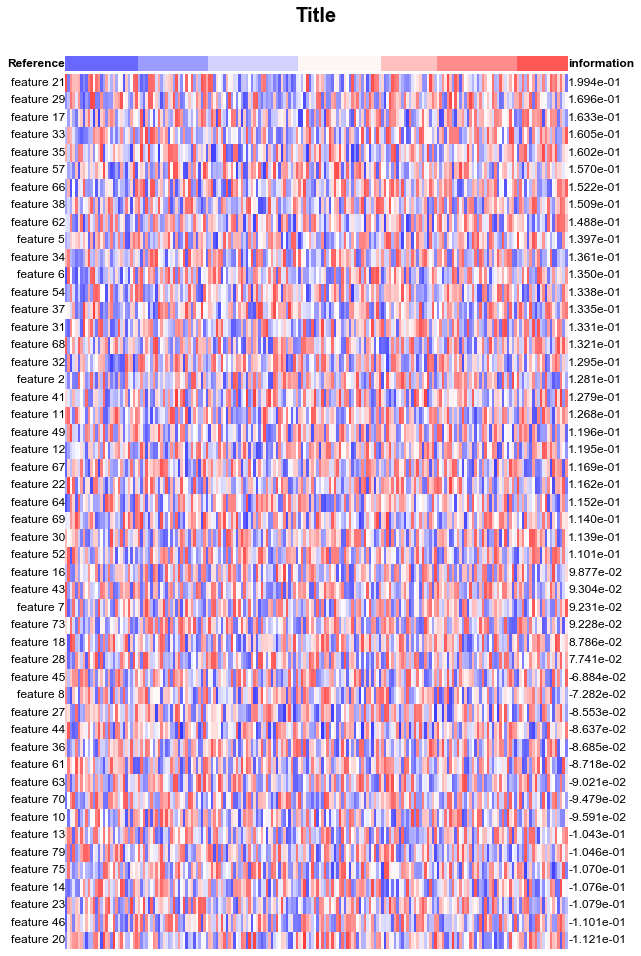

<11:03:10.916704> Saved the figure as figure.pdf.


In [43]:
rank_features(features, ref, 'information', title='Title', filename='figure', relationship='inverse')

# NMF

In [ ]:
nmf_result = ccbal.analyze.nmf(features, [3], plot=True)

In [ ]:
ns, runtimes = ccbal.support.runtime(ccbal.information.information_coefficient, n_range=range(10))

In [ ]:
from scipy.stats import pearsonr
ns, runtimes = ccbal.support.runtime(pearsonr, n_range=range(10))

In [ ]:
# make_heatmap_panel is in the ccba/library/ccba.py
# make_heatmap_panel calls plot_heatmap_panel, which is in the ccba/library/visualize.py
# make_heatmap_panel computes IC of each features's row and the ref (target).
# In the future, we can add other computation within this function so it can compute P-Val and FDR as well.
make_heatmap_panel(features, ref, ['IC', 'P-Val'])

# XXX

In [ ]:
# Feature selection test with real data for IC, CMI diff, and CMI ratio association metrics
## Ranking 60 genes + target profile with respect to the activation profile of KRAS component 6 (BRAF/MAPK)



## Feature selection using Information Coefficient

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

IC = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    IC[i] = round(compute_information_coefficient(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
IC_order = list(np.argsort(IC, kind='quicksort'))
IC = IC[IC_order]
A_sorted = A.reindex(A.index[IC_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

IC_val = pd.Series(IC[:A.shape[0]], name = "IC")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, IC_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI diff

start_time = time.time()

gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_diff_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_diff_vals[i] = round(CMI_diff(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_diff_vals, kind='quicksort'))
CMI_diff_vals = CMI_diff_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_diff_vals[:A.shape[0]], name = "CMI diff")
features = A_sorted.head(A.shape[0])
plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")

## Feature selection using CMI ratio

start_time = time.time()


gct1 = read_gct('/Users/tamayo/UCSD_2015/signatures/paper2/analysis/top_hits.gct', fill_na=0)
gct2 = read_gct('/Users/tamayo/UCSD_2015/signatures/Onco-GPS/CCLE_RNAseq_KRAS_SALE_Late.No_HAEM.k_9.H.v1.gct', fill_na=0)

common_cols = list(set(gct1.columns) & set(gct2.columns))
A = gct1[common_cols]
B = gct2[common_cols]
target = pd.DataFrame(B.loc['KRAS_SALE_Late_Comp_C6_9'])
target = target.T

CMI_ratio_vals = np.zeros(A.shape[0])
for i in range(A.shape[0]):
    CMI_ratio_vals[i] = round(CMI_ratio(x=target.iloc[0,:], y=A.iloc[i,:]), 3)  
                
CMI_order = list(np.argsort(CMI_ratio_vals, kind='quicksort'))
CMI_ratio_vals = CMI_ratio_vals[CMI_order]
A_sorted = A.reindex(A.index[CMI_order]) 

end_time = time.time() 
print("Feature selection time %s seconds " % (end_time - start_time))

CMI_val = pd.Series(CMI_ratio_vals[:A.shape[0]], name = "CMI ratio")
features = A_sorted.head(A.shape[0])

plot_heatmap_panel_v2(target, features, CMI_val, "KRAS component 6 (BRAF/MAPK) co-essential genes")